# <center> FOOD CLASSIFICATION </center>

## Tabla de contenido
- [0 - Objetivos](#0)
- [1 - Librerías necesarias](#1)
- [2 - Helper Functions](#2)
- [3 - Carga y visualización de datos](#3)
- [4 - Modelo base](#4)
- [5 - Referencias](#5)

<a name="0"></a>
## 0. Objetivos

- Practicarme con las CONVNETs

- Utilizar flow_data_from_directory para cargar datos

- Levantar el mejor modelo desde un checkpoint

<a name="1"></a>
## 1. Librerías necesarias

In [60]:
# que no se impriman info y warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

In [86]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from tensorflow.keras import layers,callbacks,models,Sequential,losses
import seaborn as sns
from sklearn.metrics import confusion_matrix
import keras_tuner
from tensorflow import keras
from keras import backend as K
import os,zipfile,pathlib,random
import pandas as pd
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

<a name="2"></a>
## 2. Helper Functions

In [64]:
# plot random image
def view_random_image(target_dir, target_class):
  # Setup the target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)
  print(random_image)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img



# plot history
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(10,4))
    
    plt.subplot(1,2,1)
    plt.title('Training and validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Val Error')
    plt.legend()

    #plt.figure()
    plt.subplot(1,2,2)
    plt.title('Training and validation accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(hist['epoch'], hist['accuracy'],
           label='Train Accuracy')
    plt.plot(hist['epoch'], hist['val_accuracy'],
           label = 'Val Accuracy')
    plt.legend()
    plt.show()


# plot confussion matrix
def plot_confusion_matrix(model,test_data):
    actual_list = []
    pred_list = []

    # Supongamos que 'test_data' es tu conjunto de datos de prueba y 'model' es tu modelo entrenado

    # Itera sobre el conjunto de prueba
    for X_batch, y_batch in test_data:
        # Convierte las etiquetas one-hot a etiquetas numéricas
        y_batch_labels = np.argmax(y_batch, axis=1).tolist()

        # Realiza predicciones con el modelo
        y_pred = model.predict(X_batch)

        # Convierte las predicciones a etiquetas numéricas
        y_pred_labels = np.argmax(y_pred, axis=1).tolist()

        # Agrega las etiquetas reales y predichas a las listas
        actual_list.extend(y_batch_labels)
        pred_list.extend(y_pred_labels)

    # Calcula la matriz de confusión
    cm = confusion_matrix(actual_list, pred_list)

    # Visualiza la matriz de confusión con un mapa de calor
    sns.heatmap(cm, annot=True, fmt="d") #cmap="Blues"
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.show()



<a name="3"></a>
## 3. Carga y visualización de datos

In [62]:
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [63]:
# descarga de los datos

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

# Unzip our data
zip_ref = zipfile.ZipFile("10_food_classes_all_data.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2023-11-28 14:32:48--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolviendo storage.googleapis.com (storage.googleapis.com)... 2800:3f0:4002:811::201b, 2800:3f0:4002:813::201b, 2800:3f0:4002:808::201b, ...
Conectando con storage.googleapis.com (storage.googleapis.com)[2800:3f0:4002:811::201b]:443... conectado.
Petición HTTP enviada, esperando respuesta... 200 OK
Longitud: 519183241 (495M) [application/zip]
Guardando como: ‘10_food_classes_all_data.zip.1’

10_food_classes_all 100%[===================>] 495,13M  10,5MB/s    en 47s     

2023-11-28 14:33:35 (10,5 MB/s) - ‘10_food_classes_all_data.zip.1’ guardado [519183241/519183241]



In [65]:
# Walk through 10 classes of food image data
for dirpath, dirnames, filenames in os.walk("10_food_classes_all_data"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 

In [66]:
# Setup the train and test directories
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

In [67]:
# Let's get the class names
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


['114601.jpg']
Image shape: (384, 512, 3)


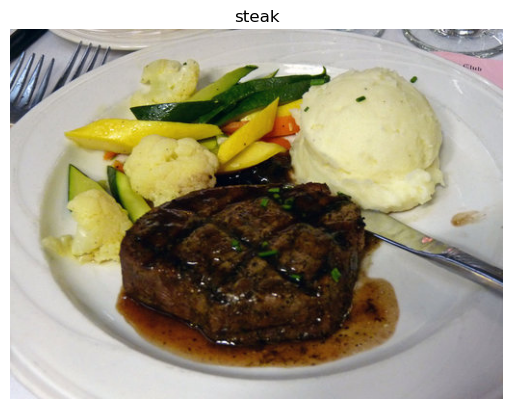

In [71]:
# Visualize, visualize, visualize
img = view_random_image(target_dir=train_dir,
                        target_class=random.choice(class_names))

Para cargar los datos usaremos "image_dataset_from_directory", que toma el path a un directorio y genera lotes de datos aumentados.
<br> 
Más info: <a href="https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory" target='_blanck'> aquí</a>   


Atributos más importantes a tener en cuenta:
    
    
- <b>classes</b>

    Lista de subdirectorios de clases (ej: ['dogs','cats']). Si no se brinda, la lista de clases será inferida automáticamente del subdirectorio nombres/estructura bajo el directorio, dond cada subdirectorio será tratado como una clase diferente (el orden de las clases, que será mapeado a los ínidices de etiquetas será alfanumérico). El diccionario que contiene el mapeo de los nombres de las clases a los índices de las clases puede ser obtenido a través del atributo class_indices.
    

- <b>class_mode</b>
    
    Determina el tipo de etiquetas que serán retornados.
    
    
    - categorical
        Etiquetas one-hot 2D
        
    - binary
        Etiquetas bianrias 1D
        
    - sparse
        Etiquetas enteras 1D
        
    - input
        Imágenes idénticas a las imágenes de entrada (más que nada utilizado con autoencoders)
        
    - None
        No se devuelven etiquetas (el generador sólo retornará lotes de datos de entrada, lo que es útil para 
        usar con model.predict.generator()).
        
        

El valor por defecto es "categorical".



Implementaremos data augmentation.

In [79]:
# ctes
(img_height, img_width) = (224,224)
batch_size = 32
input_shape = (224,224,3)


In [82]:
# Create an augmented data generator instance
train_datagen = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=0.2,
                                             width_shift_range=0.2,
                                             height_shift_range=0.2,
                                             zoom_range=0.2,
                                             horizontal_flip=True,
                                             validation_split=0.2) # set validation split



# train and validation generators

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    train_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # set as validation data


# test data (data augmentation only to train)

test_datagen = ImageDataGenerator(rescale=1/255.)

test_generator = test_datagen.flow_from_directory(test_dir,
                                             target_size=(img_height, img_width),
                                             batch_size=batch_size,
                                             class_mode="categorical")

Found 6000 images belonging to 10 classes.
Found 1500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


<a name="4"></a>
## 4. Modelo base

In [111]:
def make_model(num_classes,input_shape):
    # Create the model (this is going to be our new baseline)
    model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(10, 3, activation="relu", input_shape=input_shape),
      tf.keras.layers.MaxPool2D(pool_size=2),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Conv2D(10, 3, activation="relu"),
      tf.keras.layers.MaxPool2D(),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Conv2D(10, 3, activation="relu"),
      tf.keras.layers.MaxPool2D(),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(num_classes, activation="softmax")
    ])
    return model


model = make_model(len(class_names),input_shape)


In [112]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 111, 111, 10)     0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 111, 111, 10)      0         
                                                                 
 conv2d_10 (Conv2D)          (None, 109, 109, 10)      910       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 54, 54, 10)       0         
 g2D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 54, 54, 10)       

In [113]:
# Compile the model
model.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),                
                metrics=["accuracy"])


Vamos a entrenar el modelo pero lo cortaremos a la mitad (simulando así una falla), para retomarlo luego a partir del mejor checkpoint.

In [114]:
# callbacks


#https://keras.io/api/callbacks/model_checkpoint/

# Especifica la ubicación para guardar los puntos de control
checkpoint_path = "model_checkpoint.h5"

# Configura un ModelCheckpoint para guardar el mejor modelo basado en la métrica de validación
checkpoint_callback = ModelCheckpoint(checkpoint_path, 
                                      monitor='val_loss',
                                      save_best_only=True, # sólo guarda el mejor
                                      mode='min') # es min porque usamos val_loss


# fit
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    callbacks=checkpoint_callback,
    epochs = 10)



Epoch 1/10
187/187 [==============================] - 107s 565ms/step - loss: 2.2836 - accuracy: 0.1366 - val_loss: 2.2331 - val_accuracy: 0.1671
Epoch 2/10
187/187 [==============================] - 98s 522ms/step - loss: 2.1822 - accuracy: 0.2017 - val_loss: 2.2039 - val_accuracy: 0.1875
Epoch 3/10
187/187 [==============================] - 99s 531ms/step - loss: 2.1148 - accuracy: 0.2374 - val_loss: 2.1299 - val_accuracy: 0.2371
Epoch 4/10
187/187 [==============================] - 97s 515ms/step - loss: 2.0695 - accuracy: 0.2622 - val_loss: 2.1092 - val_accuracy: 0.2276
Epoch 5/10
187/187 [==============================] - 98s 521ms/step - loss: 2.0373 - accuracy: 0.2778 - val_loss: 2.0588 - val_accuracy: 0.2894
Epoch 6/10
 72/187 [==========>...................] - ETA: 53s - loss: 1.9913 - accuracy: 0.2843

KeyboardInterrupt: 

In [116]:
# Carga el modelo desde el punto de control
best_model = load_model(checkpoint_path)

In [117]:
# retomamos el entrenamiento
history = best_model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    callbacks=checkpoint_callback,
    epochs = 5)


Epoch 1/5
187/187 [==============================] - 101s 537ms/step - loss: 2.0029 - accuracy: 0.2981 - val_loss: 2.0650 - val_accuracy: 0.2486
Epoch 2/5
187/187 [==============================] - 99s 526ms/step - loss: 1.9992 - accuracy: 0.2971 - val_loss: 2.0260 - val_accuracy: 0.2853
Epoch 3/5
187/187 [==============================] - 102s 545ms/step - loss: 1.9734 - accuracy: 0.3061 - val_loss: 2.0157 - val_accuracy: 0.2908
Epoch 4/5
187/187 [==============================] - 100s 532ms/step - loss: 1.9681 - accuracy: 0.3073 - val_loss: 2.0270 - val_accuracy: 0.2717
Epoch 5/5
187/187 [==============================] - 100s 536ms/step - loss: 1.9396 - accuracy: 0.3241 - val_loss: 1.9670 - val_accuracy: 0.3125


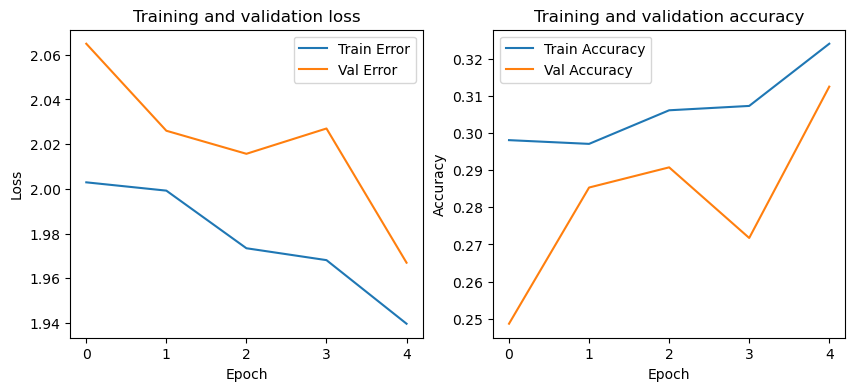

In [118]:
plot_history(history)

In [119]:
# Evalaute on the test data
scores = model.evaluate(test_data)

79/79 [==============================] - 10s 129ms/step - loss: 1.9460 - accuracy: 0.3340


In [120]:
f"La performance es {round(scores[1]*100,2)}%, debemos mejorar el modelo"

'La performance es 33.4%, debemos mejorar el modelo'

<a name="5"></a>
## 5. Referencias

- https://stackoverflow.com/questions/42443936/keras-split-train-test-set-when-using-imagedatagenerator

